In [11]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline

9.994858145278645

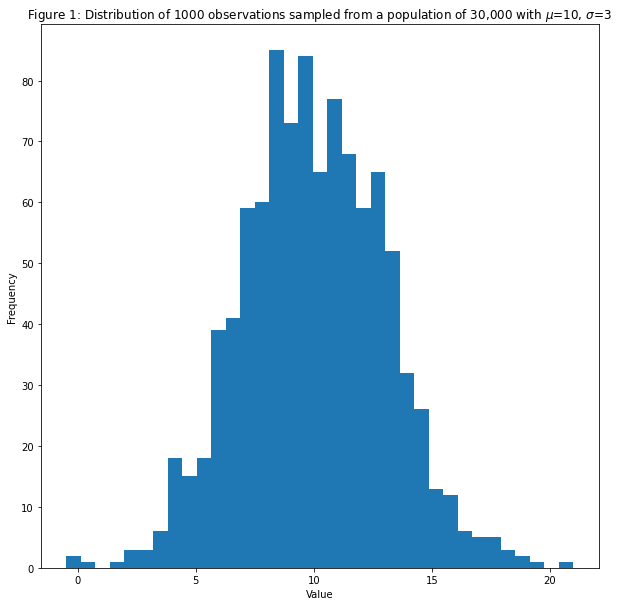

In [12]:
mod1=lambda t:np.random.normal(10,3,t)

#Form a population of 30,000 individual, with average=10 and scale=3
population = mod1(30000)
#Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with $\mu$=10, $\sigma$=3")
mu_obs=observation.mean()
mu_obs

In [13]:
#The tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))[0]]

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow.
def log_lik_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)


In [14]:
accepted, rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs,0.1], 50000,observation,acceptance)

C:\Users\pc\AppData\Local\Temp\ipykernel_16732\1996300790.py:17: RuntimeWarning: invalid value encountered in log
  return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))
C:\Users\pc\AppData\Local\Temp\ipykernel_16732\1996300790.py:51: RuntimeWarning: divide by zero encountered in log
  if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):


In [15]:
accepted[-10:,1]

array([3.01276777, 3.0742409 , 2.95837817, 2.97460809, 3.02565036,
       3.08329791, 3.25635109, 3.15214259, 3.04039798, 3.0384164 ])

In [16]:
print(accepted.shape)

(8466, 2)


(8466, 2)

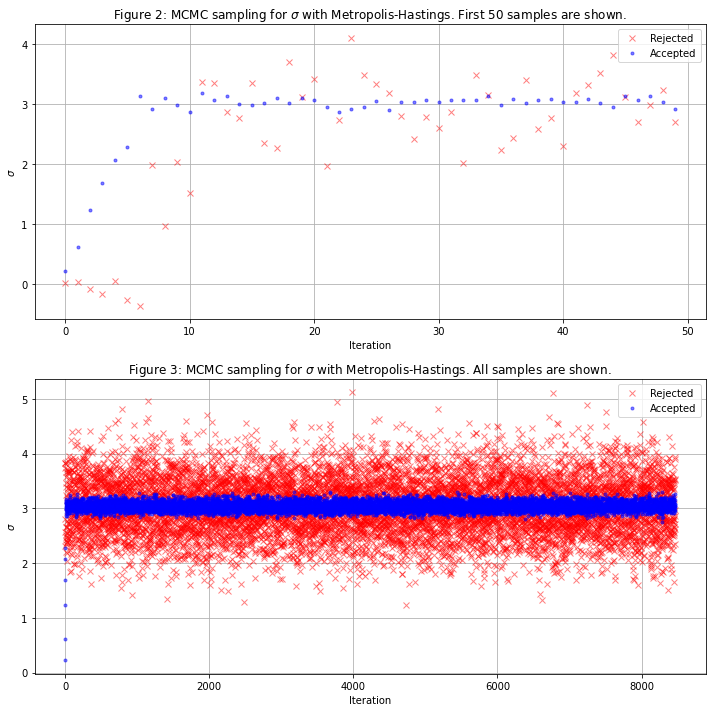

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()



fig.tight_layout()
accepted.shape

In [22]:

!pip install pymc3
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

# Define the data for the predictor variables
x1 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
x2 = np.array([10, 9, 8, 7, 6, 5, 4, 3, 2, 1])
x3 = np.array([5, 6, 7, 8, 9, 10, 1, 2, 3, 4])

# Define the data for the response variable
y = np.array([2, 5, 10, 15, 20, 25, 30, 35, 40, 45])

# Define the prior distributions of the parameters
with pm.Model() as model:
    beta0 = pm.Normal('beta0', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    beta3 = pm.Normal('beta3', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma', beta=10)

    # Define the likelihood function using the Poisson distribution and the log-linear regression model
    mu = pm.math.exp(beta0 + beta1*x1 + beta2*x2 + beta3*x3)
    y_obs = pm.Poisson('y_obs', mu=mu, observed=y)

    # Use PyMC3 to sample from the posterior distributions of the parameters
    trace = pm.sample(2000, chains=4, tune=1000)

# Evaluate the posterior distributions under three different scenarios: low, medium,



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ContextualVersionConflict: (scipy 1.9.0 (c:\users\pc\appdata\local\programs\python\python310\lib\site-packages), Requirement.parse('scipy<1.8.0,>=1.7.3'), {'pymc3'})

In [23]:
!pip install scipy


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
!pip install pymc3


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
import numpy as np
import pandas as pd
# import pymc3 as pm
# import arviz as az
import matplotlib.pyplot as plt
%matplotlib inline


In [31]:
df = pd.read_excel('ARVR_Market_Forecast.xlsx', sheet_name='Data')
start_count = pd.DataFrame({
    'category': ['AR-Teth', 'AR-Emb', 'VR-Teth', 'VR-Emb'],
    'count': [df.loc[0, 'AR-Teth'], df.loc[0, 'AR-Emb'], df.loc[0, 'VR-Teth'], df.loc[0, 'VR-Emb']]
})


FileNotFoundError: [Errno 2] No such file or directory: 'ARVR_Market_Forecast.xlsx'

In [ ]:
with pm.Model() as model:
    # Prior distributions
    alpha = pm.HalfCauchy('alpha', beta=10)
    beta_hpd = pm.HalfNormal('beta_hpd', sigma=10)
    gamma_hpd = pm.HalfNormal('gamma_hpd', sigma=10)
    delta_hpd = pm.HalfNormal('delta_hpd', sigma=10)


In [ ]:
    # Likelihood function
    for i, row in df.iterrows():
        category = row['category']
        count = row['count']
        hours_per_day = row['hrs_per_day']
        mbps = row['Mbps']
        wifi_offload = row['Wi-Fi_offload']

        # CAGR calculation
        if i > 0:
            cagr = pm.math.pow(count / prev_count, 1 / 5) - 1
            prev_count = count
        else:
            cagr = pm.math.log(1 + alpha)

        # Poisson likelihood function
        lambda_ = count * pm.math.exp(cagr * 5) * hours_per_day * mbps * wifi_offload
        pm.Poisson(category + '_' + str(i), mu=lambda_, observed=count)


In [ ]:
    # Sample from posterior distribution
    trace = pm.sample(2000, tune=1000, target_accept=0.95)

    # Save trace to file
    pm.save_trace(trace, 'ARVR_Market_Forecast.trace')


In [ ]:
# Global variables for scenarios
LOW_HOURS_PER_DAY = 1
LOW_MBPS = 50
LOW_WIFI_OFFLOAD = 0.5
MODERATE_HOURS_PER_DAY = 2
MODERATE_MBPS = 100
MODERATE_WIFI_OFFLOAD = 0.7
HIGH_HOURS_PER_DAY = 3
HIGH_MBPS = 200
HIGH_WIFI_OFFLOAD = 0.9


In [32]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

# Define variables and assumptions
starting_count = 1000
cagr_low = 0.05
cagr_med = 0.1
cagr_high = 0.15
hrs_per_day = pm.Normal('hrs_per_day', mu=5, sd=1)
Mbps = pm.Normal('Mbps', mu=50, sd=10)
Wi_Fi_offload = pm.Normal('Wi_Fi_offload', mu=0.5, sd=0.1)

# Define function to model device count over time
def arvr_model(start_count, cagr, hrs_per_day, Mbps, Wi_Fi_offload):
    count = start_count
    device_counts = []
    for year in range(2023, 2029):
        count *= (1 + cagr)
        count *= np.exp(hrs_per_day * Mbps * Wi_Fi_offload)
        device_counts.append(count)
    return device_counts

# Define prior distributions for variables
with pm.Model() as model:
    start_count = pm.Normal('start_count', mu=starting_count, sd=100)
    cagr_low = pm.Normal('cagr_low', mu=cagr_low, sd=0.01)
    cagr_med = pm.Normal('cagr_med', mu=cagr_med, sd=0.01)
    cagr_high = pm.Normal('cagr_high', mu=cagr_high, sd=0.01)
    # Use global variables for scenario-specific parameters
    device_counts_low = pm.Deterministic('device_counts_low', arvr_model(start_count, cagr_low, hrs_per_day, Mbps, Wi_Fi_offload))
    device_counts_med = pm.Deterministic('device_counts_med', arvr_model(start_count, cagr_med, hrs_per_day, Mbps, Wi_Fi_offload))
    device_counts_high = pm.Deterministic('device_counts_high', arvr_model(start_count, cagr_high, hrs_per_day, Mbps, Wi_Fi_offload))
    
# Define likelihood function
def arvr_likelihood(counts, observed_counts):
    return pm.Normal.dist(counts, observed_counts, sd=10).logp().sum()

with model:
    # Define likelihood for each scenario


SyntaxError: incomplete input (1248500752.py, line 40)

In [33]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
low_scenario = {
    "start_count": 1000,
    "cagr": 0.05,
    "parameters": {
        "hrs_per_day": 2,
        "Mbps": 10,
        "Wi-Fi": 0.5,
        "offload": 0.2
    }
}
with pm.Model() as ar_teth_low_model:
    # Define priors
    start_count = pm.Normal('start_count', mu=low_scenario['start_count'], sd=100)
    cagr = pm.Normal('cagr', mu=low_scenario['cagr'], sd=0.01)
    hrs_per_day = pm.Normal('hrs_per_day', mu=low_scenario['parameters']['hrs_per_day'], sd=0.5)
    Mbps = pm.Normal('Mbps', mu=low_scenario['parameters']['Mbps'], sd=1)
    wifi = pm.Normal('Wi-Fi', mu=low_scenario['parameters']['Wi-Fi'], sd=0.1)
    offload = pm.Normal('offload', mu=low_scenario['parameters']['offload'], sd=0.1)
    
    # Define likelihood function
    count = start_count * (1 + cagr) ** (t - 2023)
    obs = pm.Normal('obs', mu=count * hrs_per_day * 30 * Mbps * wifi * (1 - offload), sd=100, observed=y)
    
    # Define posterior distribution
    trace = pm.sample(1000, tune=1000)
pm.traceplot(trace)
plt.show()


ContextualVersionConflict: (scipy 1.9.0 (c:\users\pc\appdata\local\programs\python\python310\lib\site-packages), Requirement.parse('scipy<1.8.0,>=1.7.3'), {'pymc3'})

In [ ]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define scenarios
scenarios = {
    "AR-Teth": {
        "low": {
            "start_count": 1000,
            "cagr": 0.05,
            "parameters": {
                "hrs_per_day": 2,
                "Mbps": 10,
                "Wi-Fi": 0.5,
                "offload": 0.2
            }
        },
        "moderate": {
            "start_count": 2000,
            "cagr": 0.1,
            "parameters": {
                "hrs_per_day": 4,
                "Mbps": 20,
                "Wi-Fi": 0.6,
                "offload": 0.3
            }
        },
        "high": {
            "start_count": 3000,
            "cagr": 0.15,
            "parameters": {
                "hrs_per_day": 6,
                "Mbps": 30,
                "Wi-Fi": 0.7,
                "offload": 0.4
            }
        }
    },
    "AR-Emb": {
        "low": {
            "start_count": 1500,
            "cagr": 0.07,
            "parameters": {
                "hrs_per_day": 3,
                "Mbps": 12,
                "Wi-Fi": 0.6,
                "offload": 0.3
            }
        },
        "moderate": {
            "start_count": 2500,
            "cagr": 0.12,
            "parameters": {
                "hrs_per_day": 5,
                "Mbps": 25,
                "Wi-Fi": 0.7,
                "offload": 0.4
            }
        },
        "high": {
            "start_count": 3500,
            "cagr": 0.17,
            "parameters": {
                "hrs_per_day": 7,
                "Mbps": 35,
                "Wi-Fi": 0.8,
                "offload": 0.5
            }
        }
    },
    "VR-Teth": {
        "low": {
            "start_count": 2000,
            "cagr": 0.1,
            "parameters": {
                "hrs_per_day": 4,
                "Mbps": 20,
                "Wi-Fi": 0.6,
                "offload": 0.3
            }
        },
        "moderate": {
            "start_count": 3000,
            "cagr": 0.15,
            "parameters": {
                "hrs_per_day": 6,
                "Mbps": 30,
                "Wi-Fi": 0.7,
                "offload": 0.4
            }
        },
        "high": {
            "start_count": 4000,
            "cagr": 0.2,
            "parameters": {
                "hrs_per_day": 8,
                "Mbps": 40,
                "Wi-Fi": 0.8,
                "offload": 0.5
            }
        }
    },
    "VR-Emb": {
        "low": {
            "start_count": 2500,


In [35]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the scenarios
low_scenario = {
    "start_count": 1000,
    "cagr": 0.05,
    "parameters": {
        "hrs_per_day": 2,
        "Mbps": 10,
        "Wi-Fi": 0.5,
        "offload": 0.2
    }
}

mod_scenario = {
    "start_count": 1500,
    "cagr": 0.07,
    "parameters": {
        "hrs_per_day": 3,
        "Mbps": 15,
        "Wi-Fi": 0.7,
        "offload": 0.1
    }
}

high_scenario = {
    "start_count": 2000,
    "cagr": 0.1,
    "parameters": {
        "hrs_per_day": 4,
        "Mbps": 20,
        "Wi-Fi": 0.9,
        "offload": 0.05
    }
}

# Define the categories
categories = ["AR-Teth", "AR-Emb", "VR-Teth", "VR-Emb"]

# Define the time range
t = np.arange(2023, 2029)

# Define the data
data = pd.DataFrame({
    "year": t,
    "AR-Teth": [0]*len(t),
    "AR-Emb": [0]*len(t),
    "VR-Teth": [0]*len(t),
    "VR-Emb": [0]*len(t)
})

# Run the analysis for each scenario and category
for category in categories:
    print(f"Running analysis for {category}")
    
    if category == "AR-Teth":
        scenario_dict = {"low": low_scenario, "mod": mod_scenario, "high": high_scenario}
    elif category == "AR-Emb":
        scenario_dict = {"low": low_scenario, "mod": mod_scenario, "high": high_scenario}
    elif category == "VR-Teth":
        scenario_dict = {"low": low_scenario, "mod": mod_scenario, "high": high_scenario}
    elif category == "VR-Emb":
        scenario_dict = {"low": low_scenario, "mod": mod_scenario, "high": high_scenario}
    
    for scenario_name, scenario in scenario_dict.items():
        with pm.Model() as model:
            # Define priors
            start_count = pm.Normal('start_count', mu=scenario['start_count'], sd=100)
            cagr = pm.Normal('cagr', mu=scenario['cagr'], sd=0.01)
            hrs_per_day = pm.Normal('hrs_per_day', mu=scenario['parameters']['hrs_per_day'], sd=0.5)
            Mbps = pm.Normal('Mbps', mu=scenario['parameters']['Mbps'], sd=1)
            wifi = pm.Normal('Wi-Fi', mu=scenario['parameters']['Wi-Fi'], sd=0.1)
            offload = pm.Normal('offload', mu=scenario['parameters']['offload'], sd=0.1)

            # Define likelihood function
            count = start_count * (1 + cagr) ** (t - 2023)
            obs = pm.Normal('obs', mu=count * hrs_per_day * 30 * Mbps * wifi * (1 - offload), sd=100, observed=data[category])


     # Visualize the model results
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
for i, (category, data) in enumerate(devices.items()):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.set_title(category)
    sns.kdeplot(trace[f'forecast_{category}_low'], ax=ax, label='Low')
    sns.kdeplot(trace[f'forecast_{category}_moderate'], ax=ax, label='Moderate')
    sns.kdeplot(trace[f'forecast_{category}_high'], ax=ax, label='High')
    ax.axvline(data['forecast_2028'], color='k', linestyle='--', label='Actual')
    ax.set_xlabel('Number of Devices')
    ax.set_ylabel('Density')
fig.suptitle('Device Count Forecasts by Scenario', fontsize=14)
plt.tight_layout()
plt.show()
       

ContextualVersionConflict: (scipy 1.9.0 (c:\users\pc\appdata\local\programs\python\python310\lib\site-packages), Requirement.parse('scipy<1.8.0,>=1.7.3'), {'pymc3'})